In [44]:
import pandas as pd
import numpy as np
from re import T
id=0

############ load and digitize the data
data=pd.read_csv('/home/ebotian/MCM/tennis2.csv')

############

############# pre-process the data
    # fill nan with 0, and replace AD with 50
def pre_process(data):
    data = pd.get_dummies(data, columns=['winner_shot_type','serve_width','serve_depth','return_depth'])
    data = data.fillna(0)
    data = data.replace('AD', 50.0)
    #data['point_victor']=data["point_victor"].replace(2,0)
    #print(data.iloc[:,15])
    ###################################
    #for predict:
    conditions = [
        (data['server'] == 1) & (data['point_victor'] == 1),
        (data['server'] == 1) & (data['point_victor'] == 2),
        (data['server'] == 2) & (data['point_victor'] == 2),
        (data['server'] == 2) & (data['point_victor'] == 1)
    ]
    choices = ['P1_serve_win', 'P1_serve_lose', 'P2_serve_win', 'P2_serve_lose']
    data['state'] = np.select(conditions, choices, default='unknown')

    # split the data into different match
    grouped = dict(tuple(data.groupby(data['match_id'].ne(data['match_id'].shift()).cumsum())))

    # Rename the subdata
    subdata = {df['match_id'].iloc[0]: df for _, df in grouped.items()}

    # Create a new dataset from the first column, excluding duplicates
    match = pd.DataFrame(data.iloc[:, 0].drop_duplicates()).iloc[:,0].tolist()


    return subdata,match

subdata,match=pre_process(data)
#print(subdata[match[1]])
##############

def process_all_ids(subdata):
    for id in range(len(match)):
        index_array = subdata[match[id]][subdata[match[id]]['server'] == 2].index.values
#        subdata[match[id]].loc[index_array, 'point_victor'] = 1 - subdata[match[id]].loc[index_array, 'point_victor']
        target=pd.DataFrame(subdata[match[id]]["point_victor"])
        # Add the "elapsed_time" column to the "target" DataFrame
        subdata[match[id]]['elapsed_time'] = pd.to_timedelta(subdata[match[id]]['elapsed_time'])
        target.insert(0, 'elapsed_time', subdata[match[id]]['elapsed_time'])
        target['elapsed_time'] = target['elapsed_time'].dt.total_seconds()
        #subdata[match[id]]=subdata[match[id]].drop(columns=["point_victor"])
        features=subdata[match[id]].drop(columns=["point_victor"]).iloc[:,4:]

    return target,features,subdata,index_array

# Replace with your actual match ids
target,features,subdata,index_array=process_all_ids(subdata)
#print(subdata[match[1]])
##############
##############
#invert the victor when the server is 2 to get server_victor
#and after the prediction, we invert the victor again
# Get the index array


# Invert the values in the "point_victor" column for the specified rows

#print(index_array)
##############
# Calculate the time difference between consecutive rows
def get_average_interval(id, subdata):

    # Calculate the time difference between consecutive rows
    subdata[match[id]]['time_diff'] = subdata[match[id]]['elapsed_time'].diff()

    # Calculate the 5th and 95th percentiles
    lower_threshold = subdata[match[id]]['time_diff'].quantile(0.05)
    upper_threshold = subdata[match[id]]['time_diff'].quantile(0.95)

    # Exclude the top 5% and bottom 5% of periods
    filtered_diff = subdata[match[id]]['time_diff'][(subdata[match[id]]['time_diff'] > lower_threshold) & (subdata[match[id]]['time_diff'] < upper_threshold)]

    # Calculate the average of the remaining intervals
    average_interval = filtered_diff.mean()
    return average_interval.total_seconds()

average_interval_time=[]

for id in range(len(match)):
    average_interval_time.append(get_average_interval(id, subdata))

print(average_interval_time)

[43.78409, 40.59322, 39.725663, 37.31208, 39.0, 36.600706, 37.048543, 34.923076, 38.327956, 41.123674, 35.568493, 38.151639, 34.312252, 33.364197, 34.539772, 41.554794, 41.755, 41.395833, 34.773584, 34.866141, 40.021276, 35.890173, 31.554054, 37.925, 40.95238, 33.7, 37.491124, 42.31088, 37.605633, 47.819767, 47.070707]


In [45]:
import pandas as pd

def create_markov_chain(id, subdata):
  # Define extended states
  extended_states = [
    'P1_serve_win', 'P1_serve_lose',
    'P2_serve_win', 'P2_serve_lose'
  ]
  # Get the match data for the given id
  subdata[match[id]]["point_victor"]= subdata[match[id]]["point_victor"]

  # Initialize transition count matrix
  transition_counts = pd.DataFrame(0, index=extended_states, columns=extended_states)
  match_data=subdata[match[id]]

  # Iterate over the match data
  for i in range(1, len(match_data)):
    prev_point = match_data.iloc[i-1]
    curr_point = match_data.iloc[i]

    # Determine the state of the previous and current point
    prev_state = 'P{}_serve_{}'.format(prev_point['server'], 'win' if prev_point['point_victor'] == prev_point['server'] else 'lose')
    curr_state = 'P{}_serve_{}'.format(curr_point['server'], 'win' if curr_point['point_victor'] == curr_point['server'] else 'lose')

    # Update transition counts
    transition_counts.loc[prev_state, curr_state] += 1

  # Calculate transition probabilities
  transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)

  return transition_probabilities

# Initialize list to store transition matrices
transition_matrices = []

# Iterate over the range of the number of matches
for id in range(len(match)):
    # Create transition matrix for current match
    transition_matrix = create_markov_chain(id, subdata)

    # Add transition matrix to list
    transition_matrices.append(transition_matrix)

In [46]:
def create_markov_chain_p1p2(id, subdata):
  # Define states
  p1_states = ['P1_serve_win', 'P1_serve_lose']
  p2_states = ['P2_serve_win', 'P2_serve_lose']

  # Get the match data for the given id
  match_data = subdata[match[id]]
  match_data["point_victor"] = match_data["point_victor"]

  # Initialize transition count matrices
  p1_transition_counts = pd.DataFrame(0, index=p1_states, columns=p1_states)
  p2_transition_counts = pd.DataFrame(0, index=p2_states, columns=p2_states)

  # Iterate over the match data
  for i in range(1, len(match_data)):
    prev_point = match_data.iloc[i-1]
    curr_point = match_data.iloc[i]

    # Determine the state of the previous and current point
    prev_state = 'P{}_serve_{}'.format(prev_point['server'], 'win' if prev_point['point_victor'] == prev_point['server'] else 'lose')
    curr_state = 'P{}_serve_{}'.format(curr_point['server'], 'win' if curr_point['point_victor'] == curr_point['server'] else 'lose')

    # Update transition counts
    if prev_state in p1_states and curr_state in p1_states:
        p1_transition_counts.loc[prev_state, curr_state] += 1
    elif prev_state in p2_states and curr_state in p2_states:
        p2_transition_counts.loc[prev_state, curr_state] += 1

  # Calculate transition probabilities
  p1_transition_probabilities = p1_transition_counts.div(p1_transition_counts.sum(axis=1), axis=0)
  p2_transition_probabilities = p2_transition_counts.div(p2_transition_counts.sum(axis=1), axis=0)

  return p1_transition_probabilities, p2_transition_probabilities

# Initialize lists to store transition matrices
p1_transition_matrices = []
p2_transition_matrices = []

# Iterate over the range of the number of matches
for id in range(len(match)):
    # Create transition matrices for current match
    p1_transition_matrix, p2_transition_matrix = create_markov_chain_p1p2(id, subdata)

    # Add transition matrices to lists
    p1_transition_matrices.append(p1_transition_matrix)
    p2_transition_matrices.append(p2_transition_matrix)

In [47]:
print(subdata[match[id]].columns)

Index(['match_id', 'player1', 'player2', 'elapsed_time', 'set_no', 'game_no',
       'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'p1_score',
       'p2_score', 'server', 'serve_no', 'point_victor', 'p1_points_won',
       'p2_points_won', 'game_victor', 'set_victor', 'p1_ace', 'p2_ace',
       'p1_winner', 'p2_winner', 'p1_double_fault', 'p2_double_fault',
       'p1_unf_err', 'p2_unf_err', 'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won',
       'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won',
       'p2_break_pt_won', 'p1_break_pt_missed', 'p2_break_pt_missed',
       'p1_distance_run', 'p2_distance_run', 'rally_count', 'speed_mph',
       'winner_shot_type_0', 'winner_shot_type_B', 'winner_shot_type_F',
       'serve_width_B', 'serve_width_BC', 'serve_width_BW', 'serve_width_C',
       'serve_width_W', 'serve_depth_CTL', 'serve_depth_NCTL',
       'return_depth_D', 'return_depth_ND', 'state', 'time_diff'],
      dtype='object')


In [48]:
import numpy as np
from regex import P

def predict_state_sequence(subdata, id, average_interval_time, max_time):
    # Define the states
    p1_states=['P1_serve_win', 'P1_serve_lose']
    p2_states=['P2_serve_win', 'P2_serve_lose']

    # Determine the initial state
    initial_state = subdata[match[id]].iloc[0]['state']  # Assuming 'state'column holds the state information


    # Calculate the number of steps
    num_steps = int(max_time / average_interval_time)

    # Generate the sequence of states
    state_sequence = [initial_state]
    current_state = initial_state
    predict_steps=0

    while(num_steps>predict_steps):
        P1_match_win_counter=0
        P2_match_win_counter=0
        p1_point_win=[]
        p2_point_win=[]
        p1_point_win_counter=0
        p2_point_win_counter=0
        while(not(P1_match_win_counter>=3 or P2_match_win_counter>=3)):
            P1_set_win_counter=0
            P2_set_win_counter=0
            while(not ((P1_set_win_counter>=6 or P2_set_win_counter>=6)and abs(P1_set_win_counter-P2_set_win_counter)>=2)):
                if current_state == 'P1_serve_win' or current_state == 'P1_serve_lose':
                    serve=1
                else:
                    serve=2
                P1_game_win_counter = 0
                P2_game_win_counter = 0
                while (not((P1_game_win_counter >= 4 or P2_game_win_counter >= 4) and abs(P1_game_win_counter - P2_game_win_counter) >= 2)):
                    if serve==1:
                        game_matrix=p1_transition_matrices[id]
                        game_states=p1_states
                    else:
                        game_matrix=p2_transition_matrices[id]
                        game_states=p2_states
                    next_state = np.random.choice(game_states, p=game_matrix.loc[current_state].values)
                    if next_state == 'P1_serve_win' or next_state == 'P2_serve_lose':
                        P1_game_win_counter += 1
                        p1_point_win_counter+=1
                        p1_point_win.append(p1_point_win_counter)
                        p2_point_win.append(p2_point_win_counter)
                    elif next_state == 'P2_serve_win' or next_state == 'P1_serve_lose':
                        P2_game_win_counter += 1
                        p2_point_win_counter+=1
                        p1_point_win.append(p1_point_win_counter)
                        p2_point_win.append(p2_point_win_counter)
                    state_sequence.append(next_state)
                    current_state = next_state
                    predict_steps+=1
                serve=3-serve
                if(P1_game_win_counter>P2_game_win_counter):
                    P1_set_win_counter+=1
                else:
                    P2_set_win_counter+=1
            if(P1_set_win_counter>P2_set_win_counter):
                P1_match_win_counter+=1
            else:
                P2_match_win_counter+=1

    return p1_point_win,p2_point_win,P1_match_win_counter,P2_match_win_counter

# Usage:
def predict_a_subdata(subdata):
    max_time = 6*60*60  # Replace with the actual total time
    # Initialize lists to store the predicted state sequences
    p1_match_counter_list=[]
    p2_match_counter_list=[]
    predict_p1_point_win_list=[]
    predict_p2_point_win_list=[]
    # Iterate over the range of the number of matches
    for id in range(len(match)):
        predict_p1_point_win,predict_p2_point_win,p1_match_counter,p2_match_counter  = predict_state_sequence(subdata, id, average_interval_time[id], max_time)
        p1_match_counter_list.append(p1_match_counter)
        p2_match_counter_list.append(p2_match_counter)
        predict_p1_point_win_list.append(predict_p1_point_win)
        predict_p2_point_win_list.append(predict_p2_point_win)
    return predict_p1_point_win_list,predict_p2_point_win_list

def predict_a_match(id):
    max_time = 6*60*60  # Replace with the actual total time
    predict_p1_point_win,predict_p2_point_win,p1_match_counter,p2_match_counter  = predict_state_sequence(subdata, id, average_interval_time[id], max_time)
    max_time = 6*60*60  # Replace with the actual total time
    return predict_p1_point_win,predict_p2_point_win


#    state_sequence = predict_state_sequence(transition_matrices, subdata, id, average_interval_time[id], max_time)
#    #print(state_sequence)
#print(p1_match_counter_list,p2_match_counter_list)
#for id in range(len(match)):
#    print(len(predict_p1_point_win_list[id]))
#print(predict_p2_point_win_list[id])

predict_p1_point_win_list,predict_p2_point_win_list=predict_a_subdata(subdata)
predict_p1_point_win,predict_p2_point_win=predict_a_match(1)

In [49]:
accuracies = []

for id in range(len(match)):
  min_length = min(len(predict_p1_point_win_list[id]), len(subdata[match[id]]['p1_points_won']), len(predict_p2_point_win_list[id]), len(subdata[match[id]]['p2_points_won']))

  correct_predictions_p1 = np.sum(np.array(predict_p1_point_win_list[id][:min_length]) == np.array(subdata[match[id]]['p1_points_won'][:min_length]))
  correct_predictions_p2 = np.sum(np.array(predict_p2_point_win_list[id][:min_length]) == np.array(subdata[match[id]]['p2_points_won'][:min_length]))

  total_predictions = 2 * min_length  # times 2 because we're counting both p1 and p2 predictions

  match_accuracy = (correct_predictions_p1 + correct_predictions_p2) / total_predictions
  accuracies.append(match_accuracy)

# Calculate the average accuracy
accuracy = np.mean(accuracies)
print(f'Average Accuracy: {accuracy:.2f}')

Average Accuracy: 0.04


In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_matrix(transition_matrices, folder_name):
    # Create directory if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for i, transition_matrix in enumerate(transition_matrices):
        # Create a new figure for each matrix
        plt.figure(figsize=(7, 6))

        # Create a heatmap
        sns.heatmap(transition_matrix, annot=True, fmt=".2%", cmap='Blues', annot_kws={"size": 10})

        # Add a title using the value of match[id]
        title = f'Transition Matrix for {match[i]}'
        plt.title(title)

        # Save the plot in the directory
        plt.savefig(f'{folder_name}/{title}.png')

        # Show the plot
        #plt.show()

#plot_matrix(p1_transition_matrices,"p1_transition_matrices")
#plot_matrix(p2_transition_matrices,"p2_transition_matrices")
#plot_matrix(transition_matrices,"transition_matrices")

/tmp/ipykernel_25369/1322965102.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


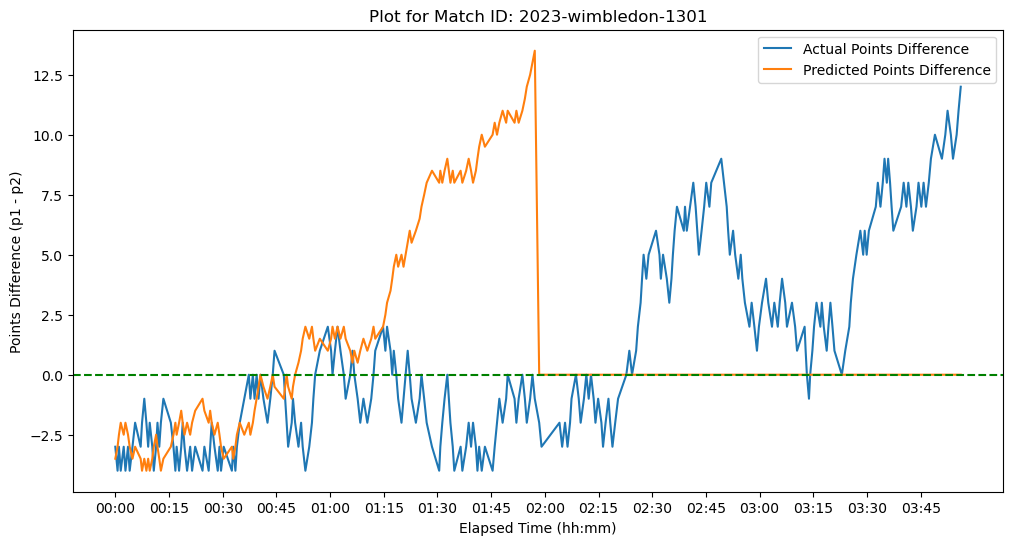

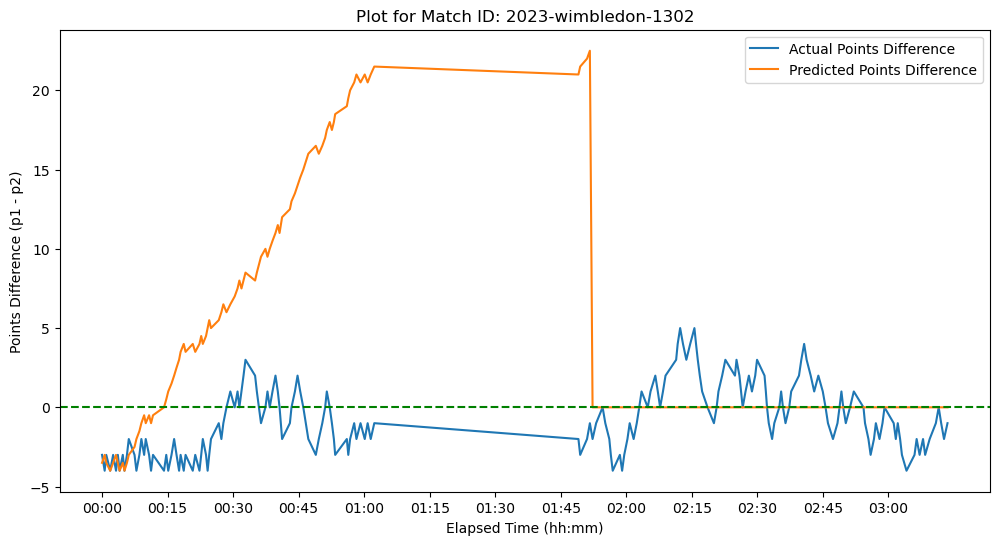

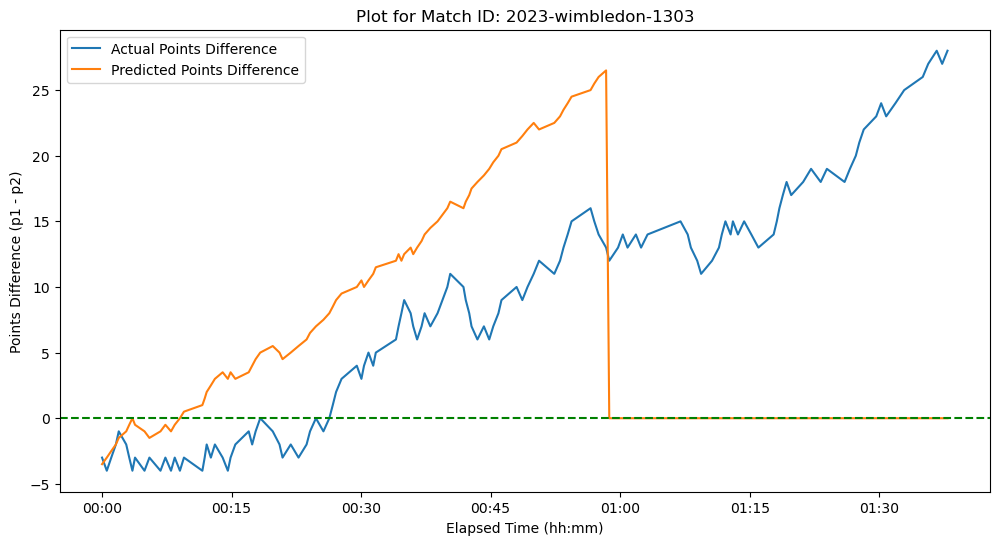

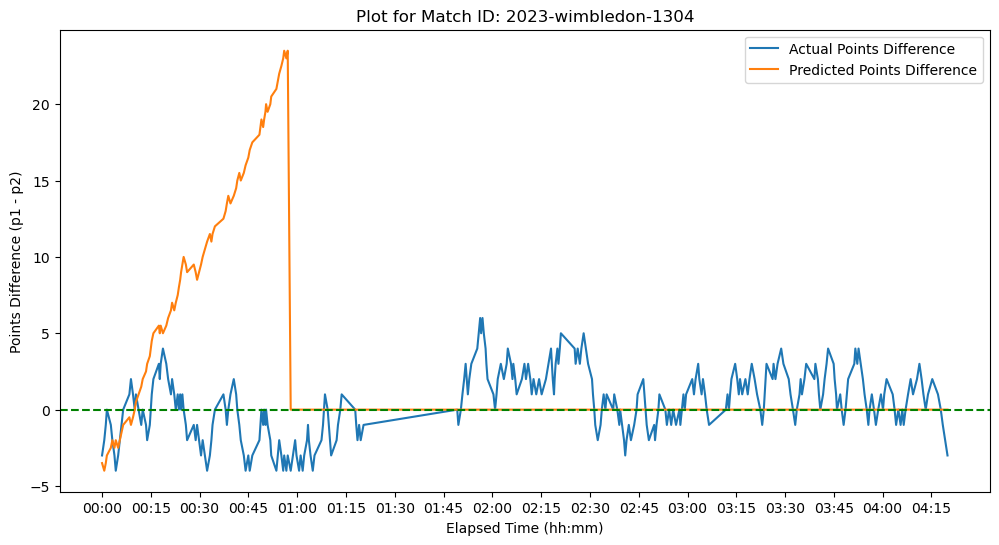

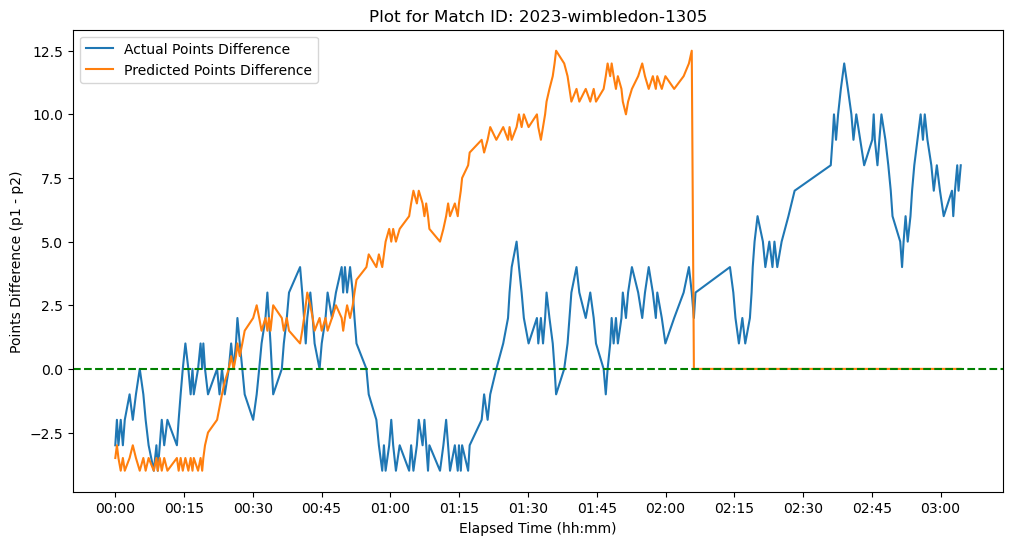

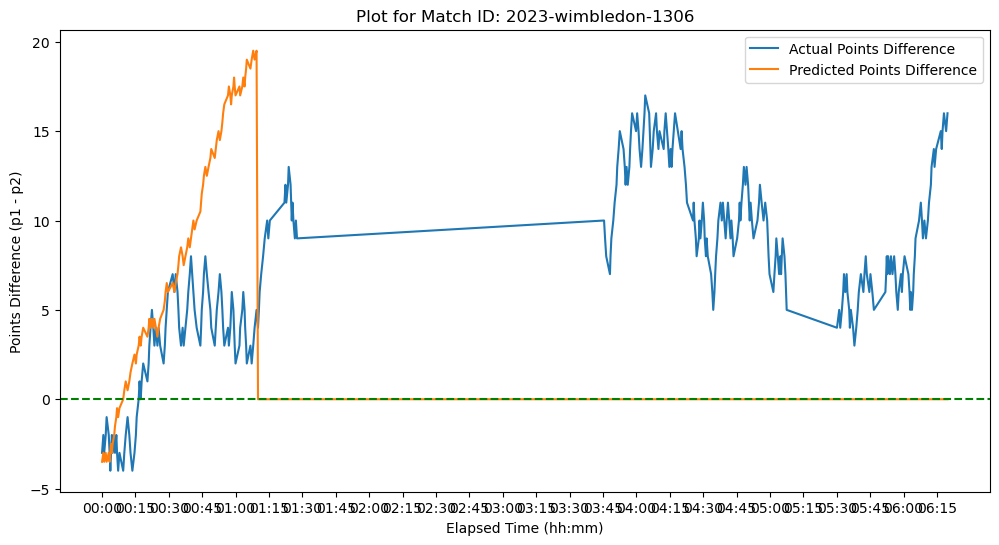

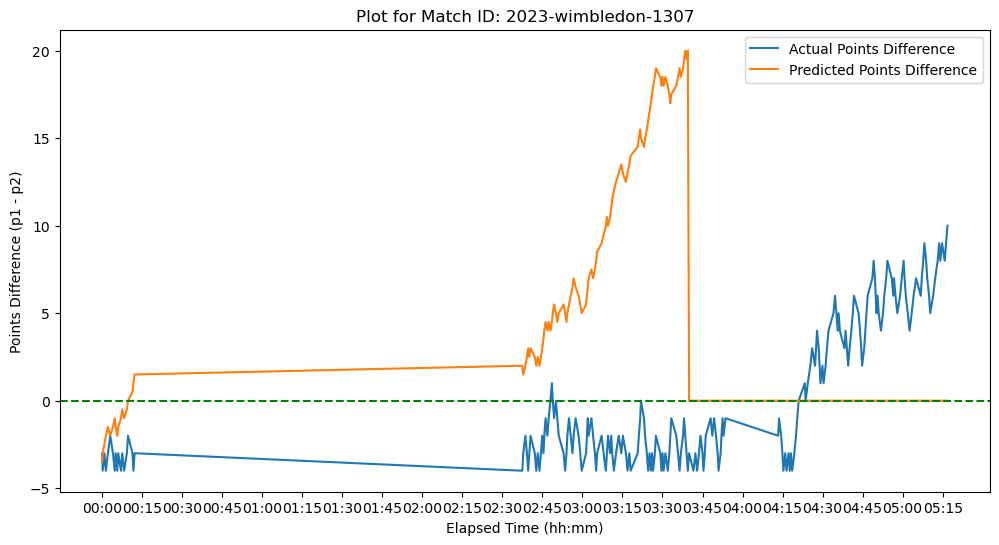

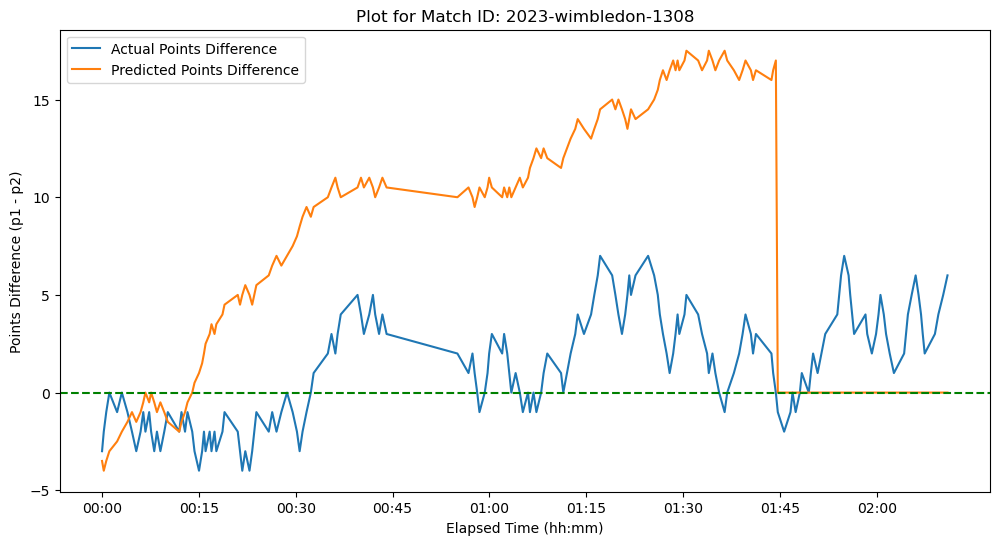

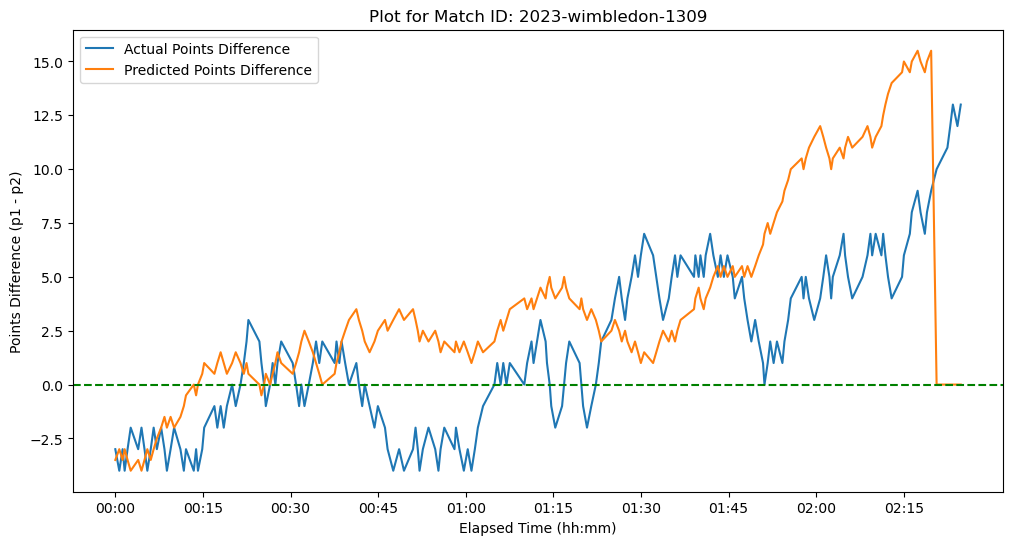

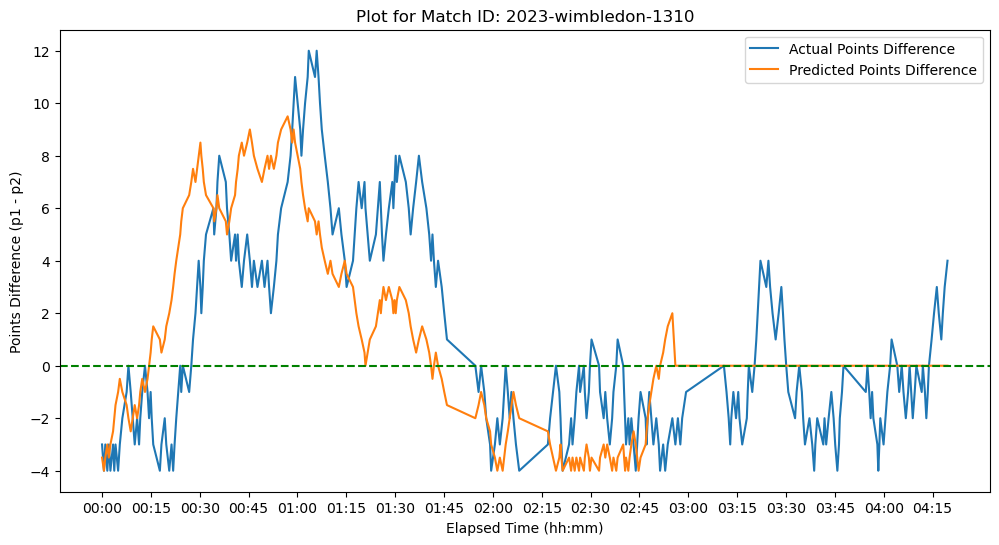

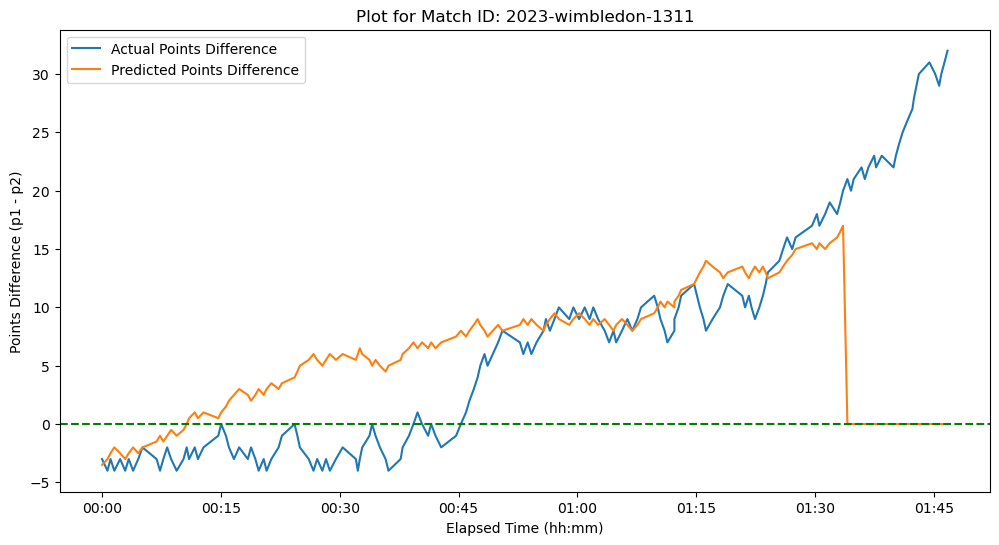

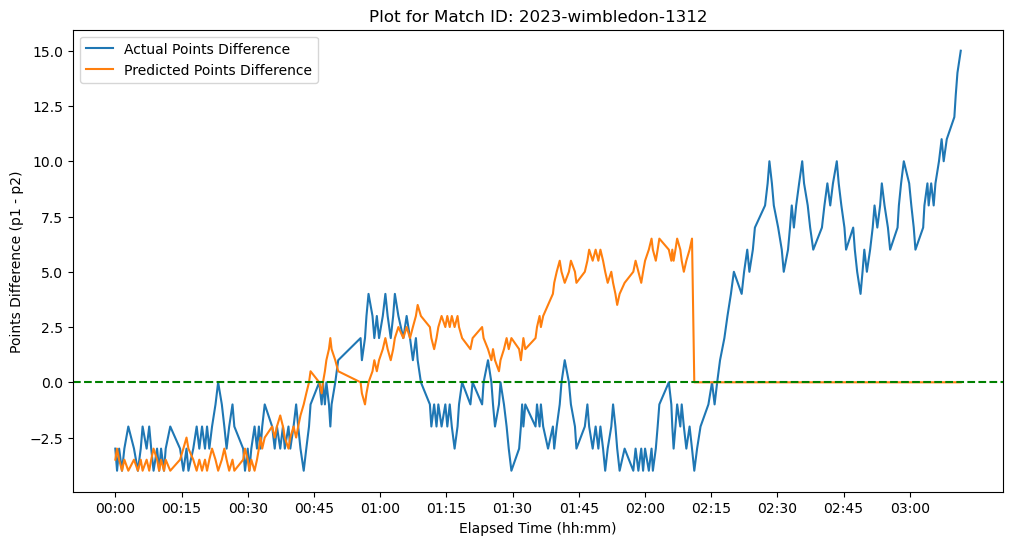

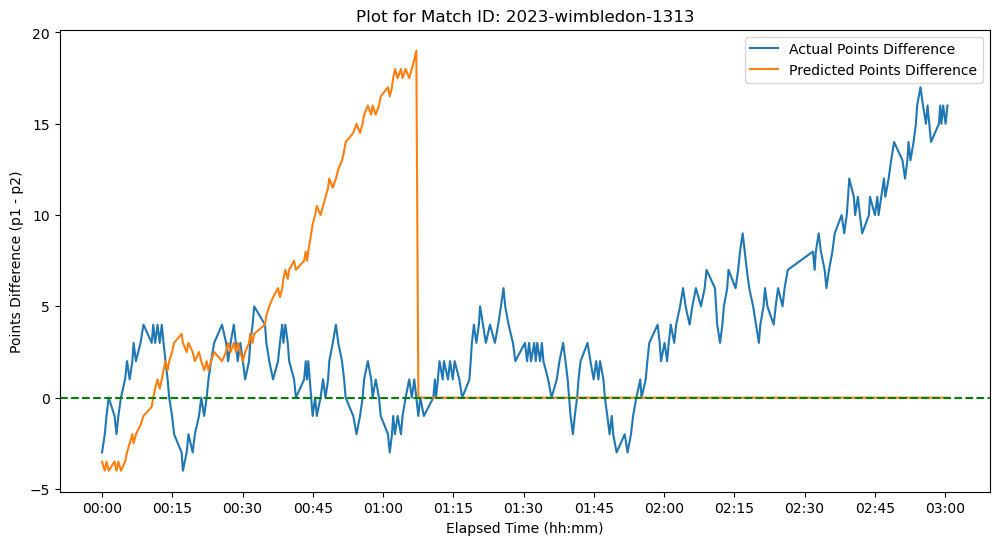

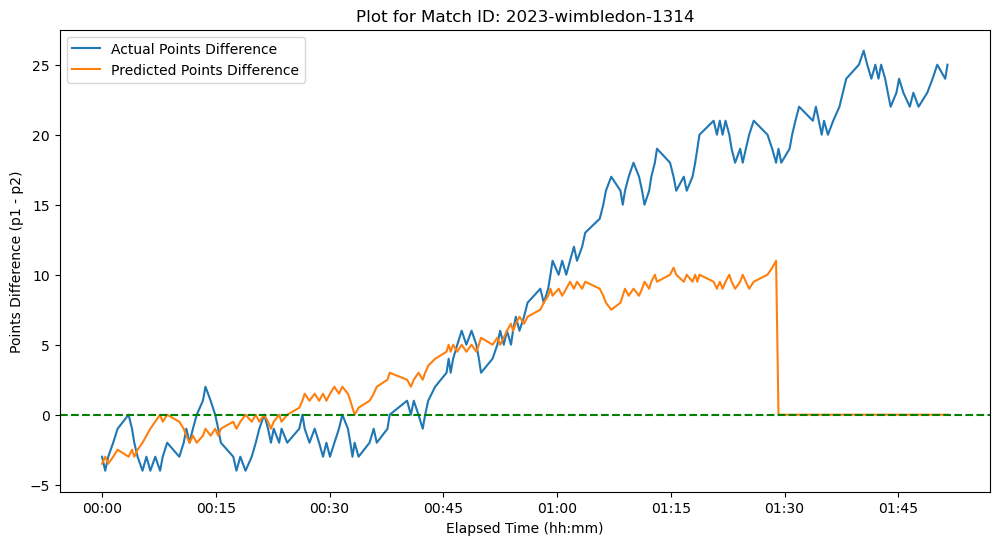

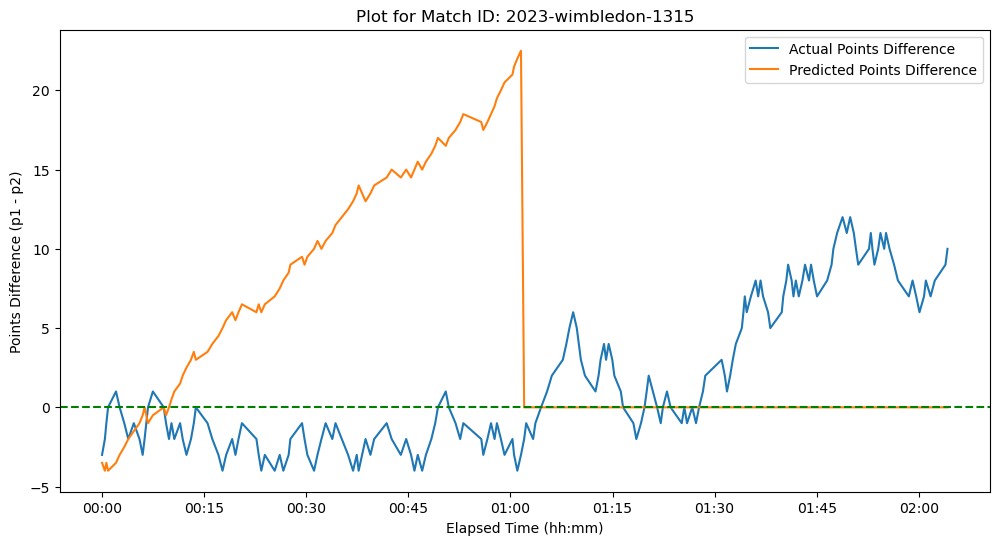

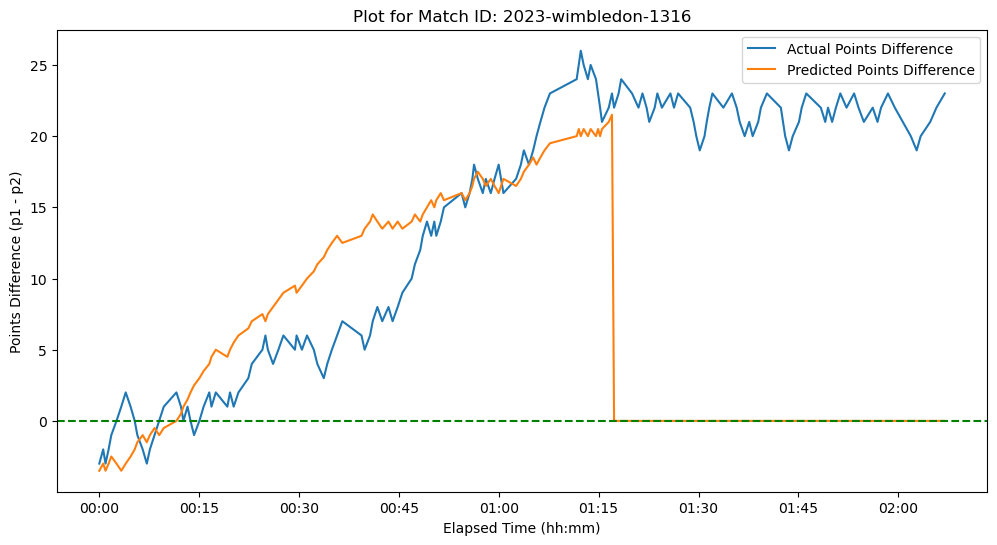

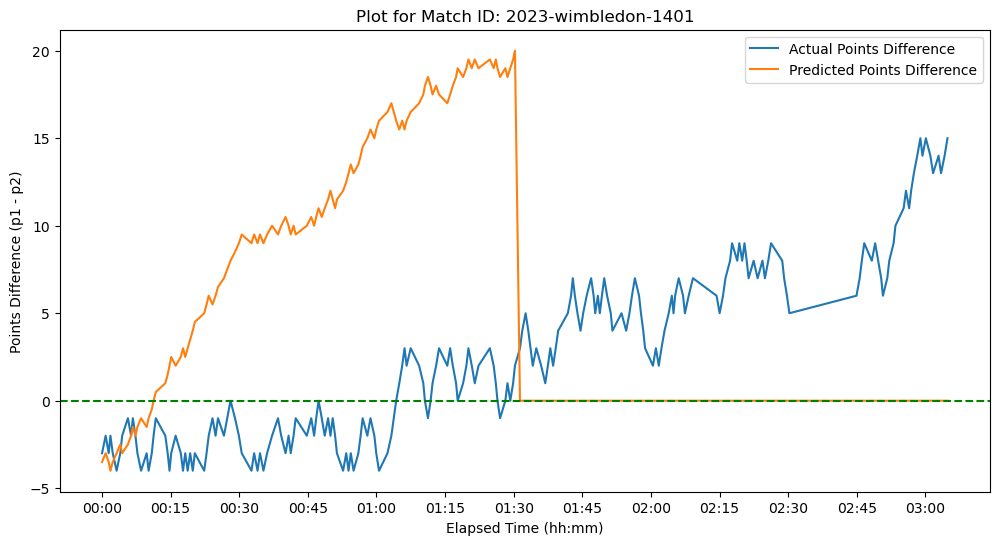

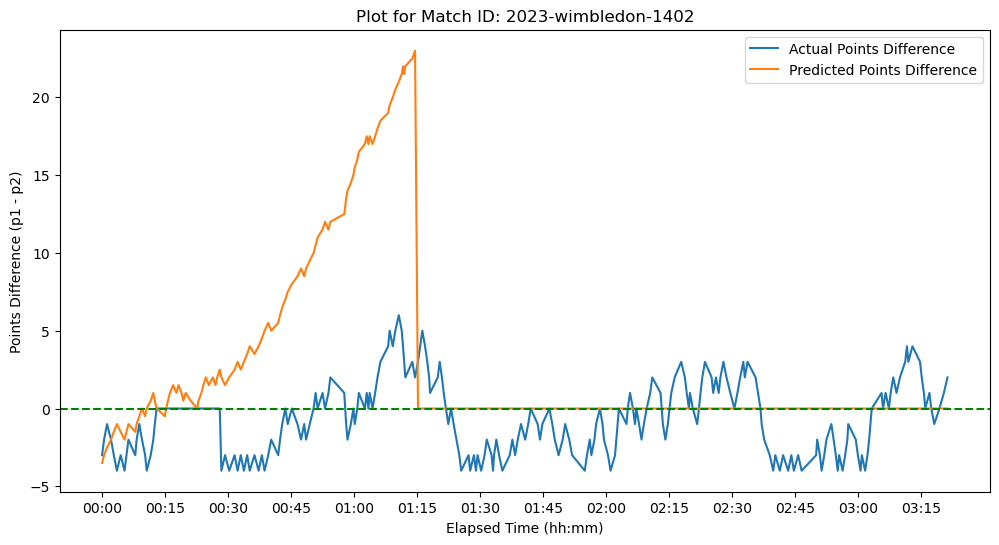

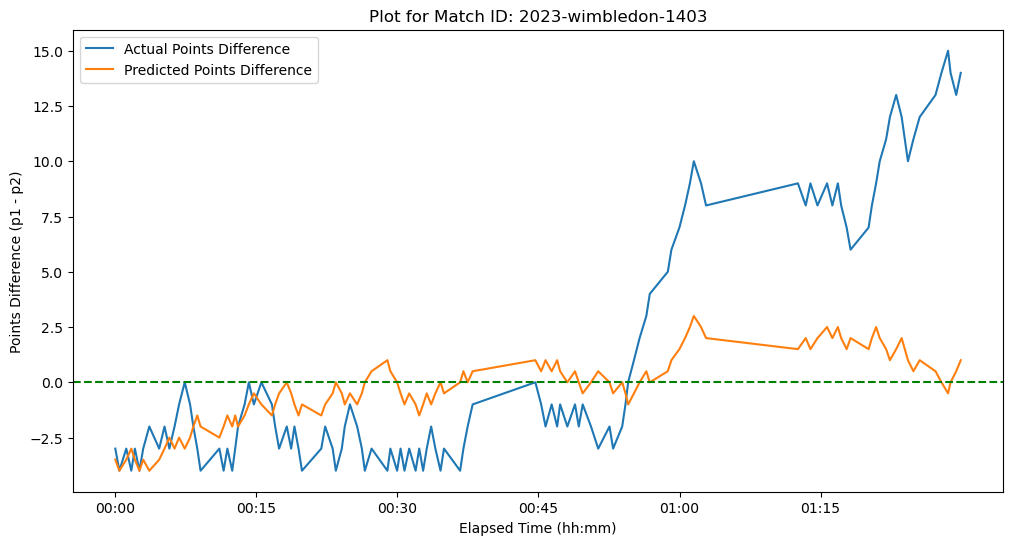

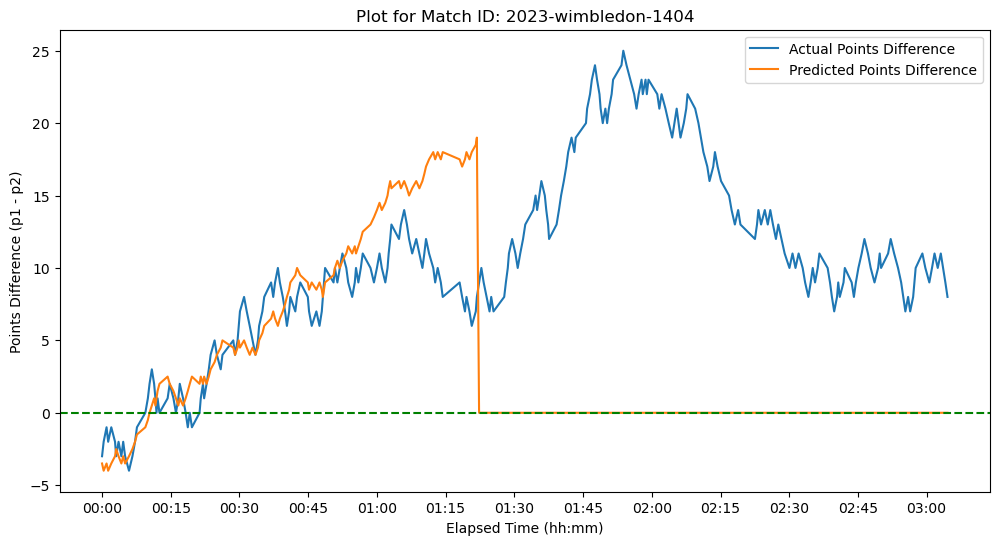

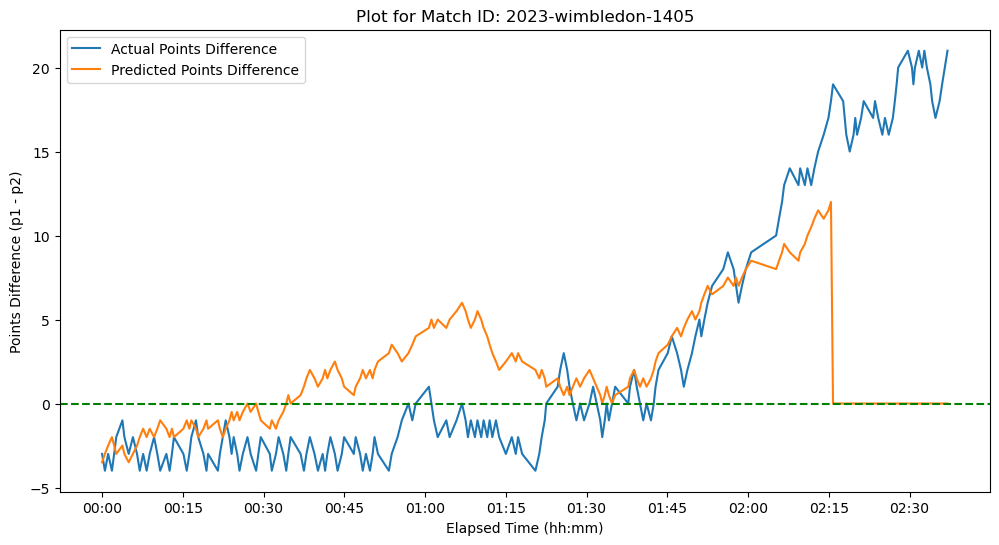

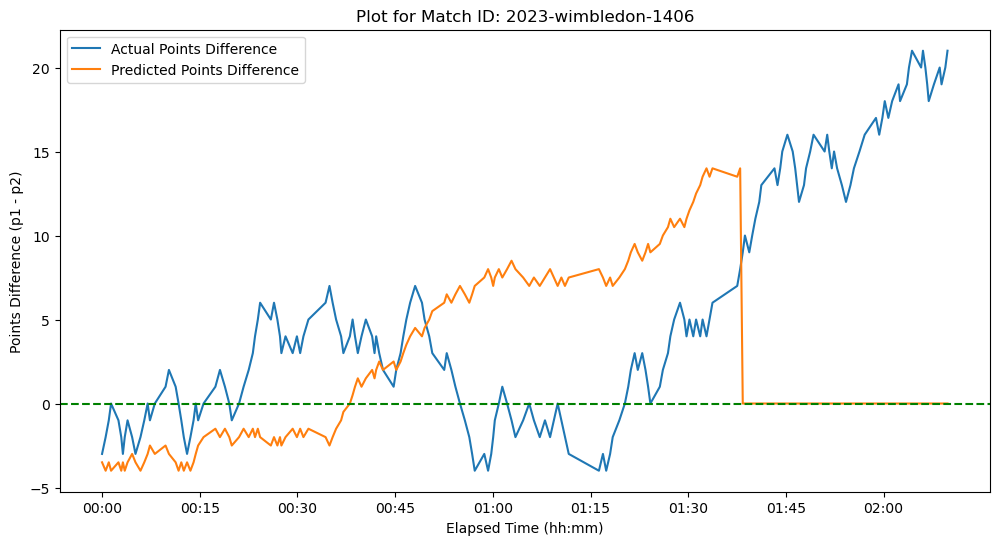

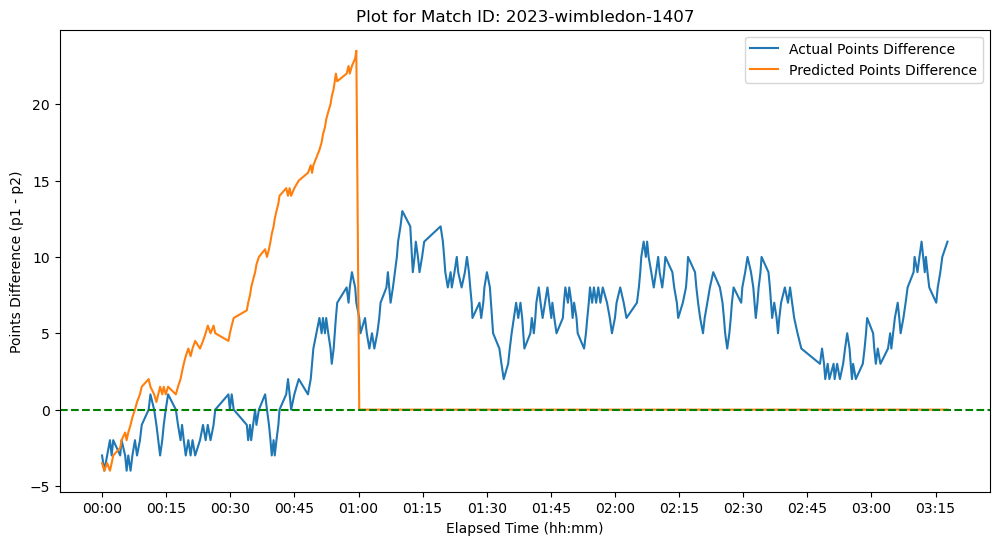

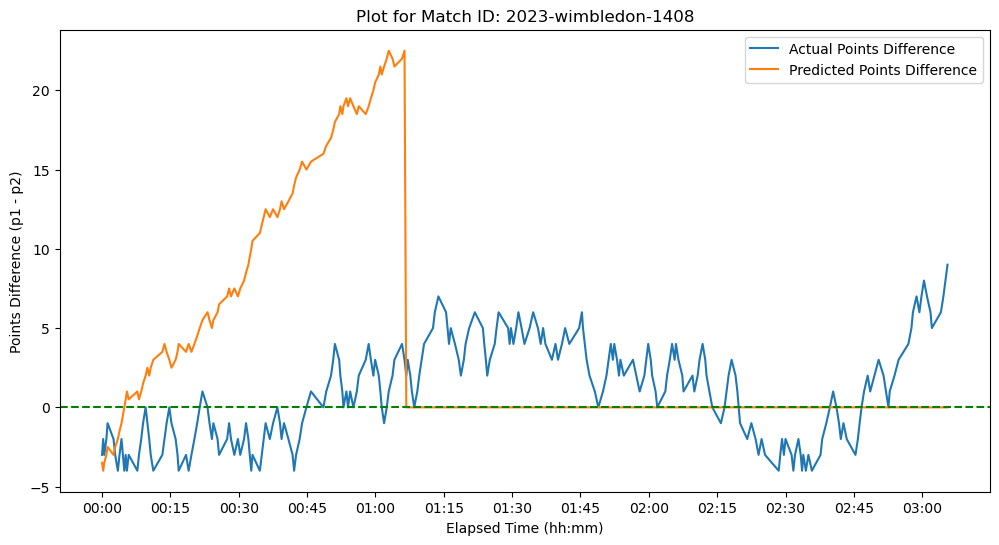

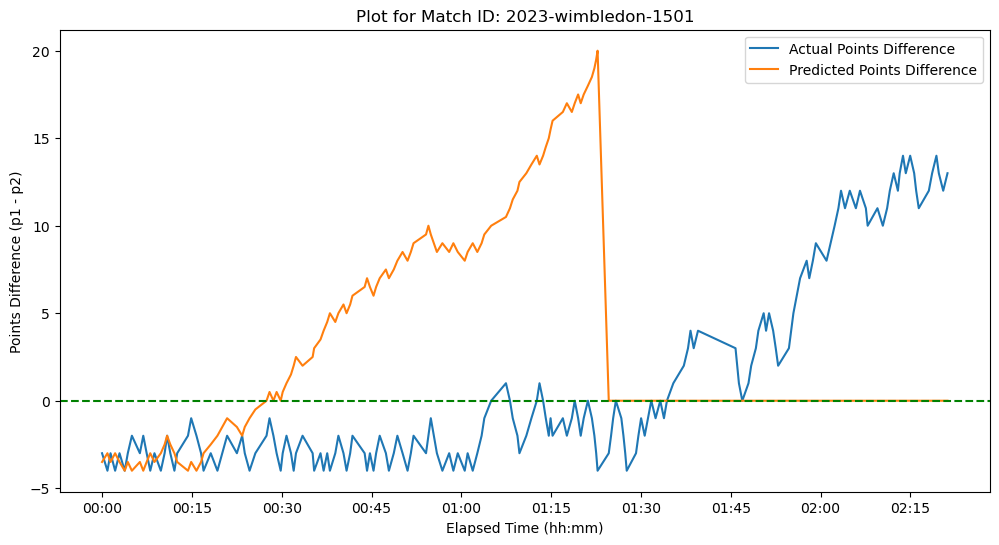

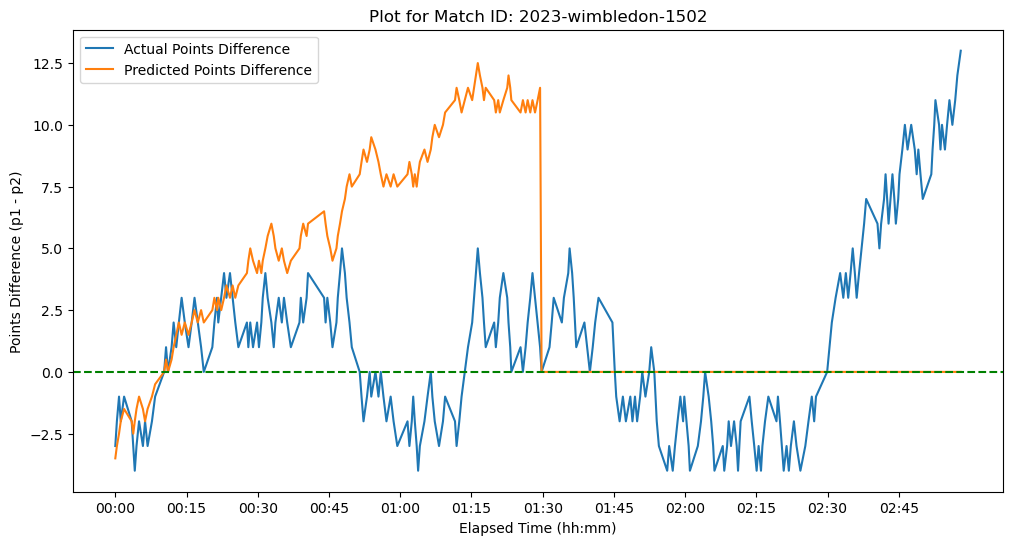

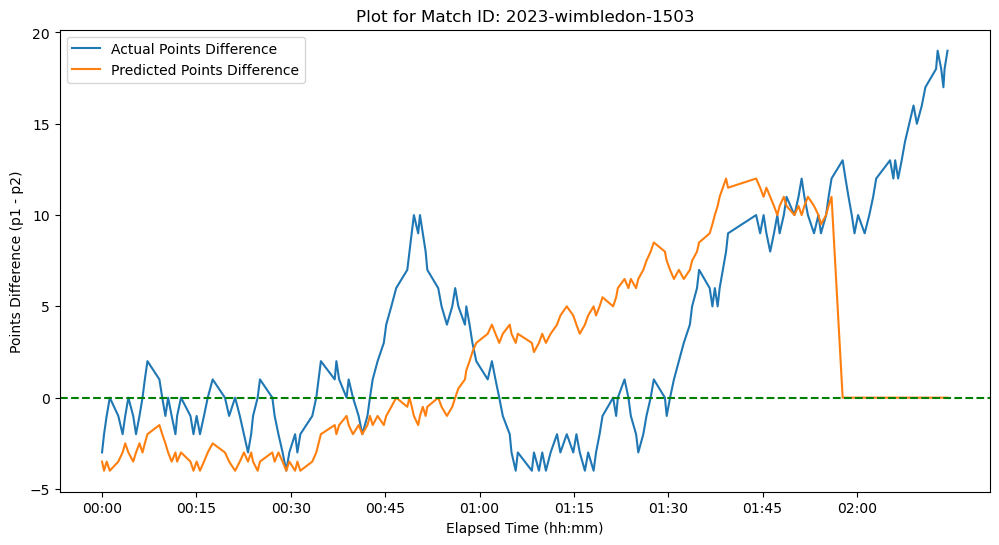

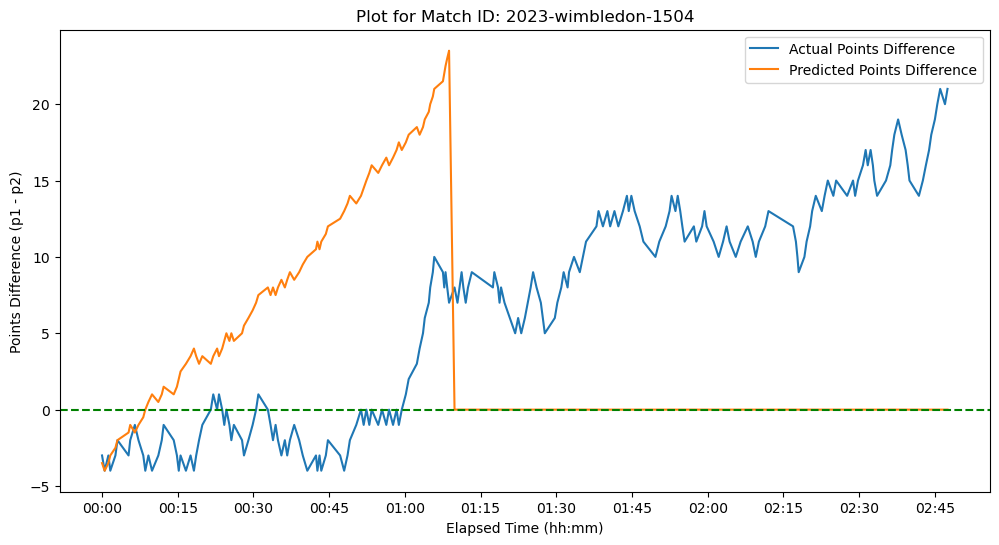

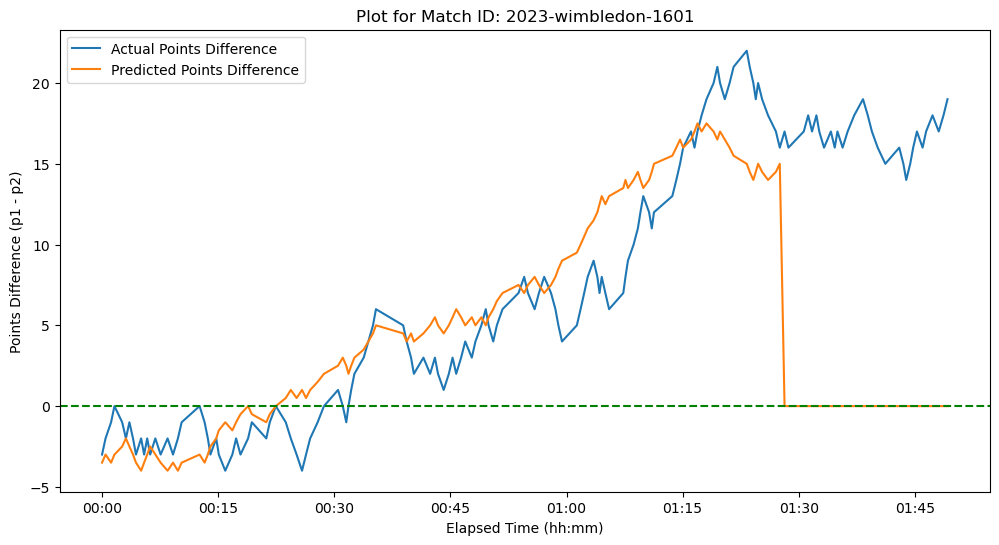

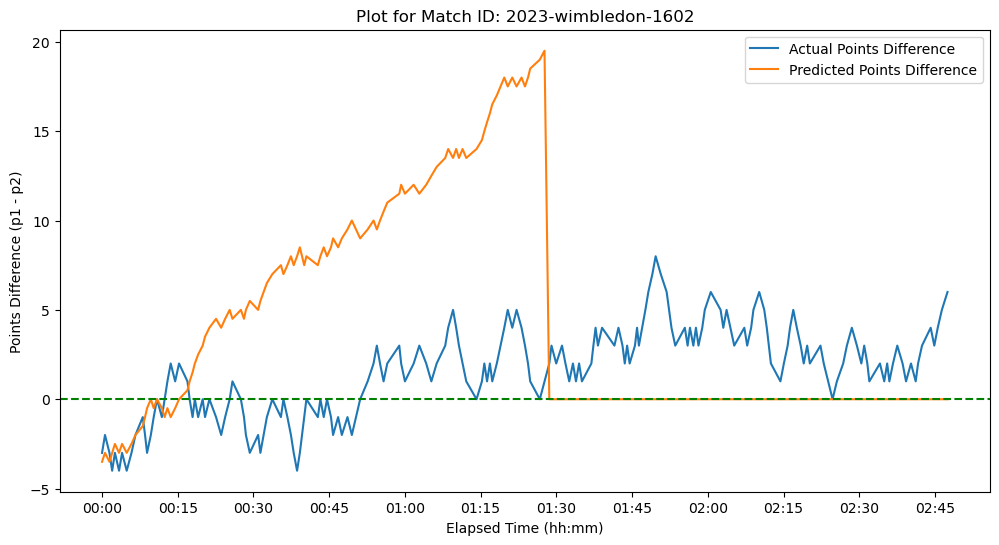

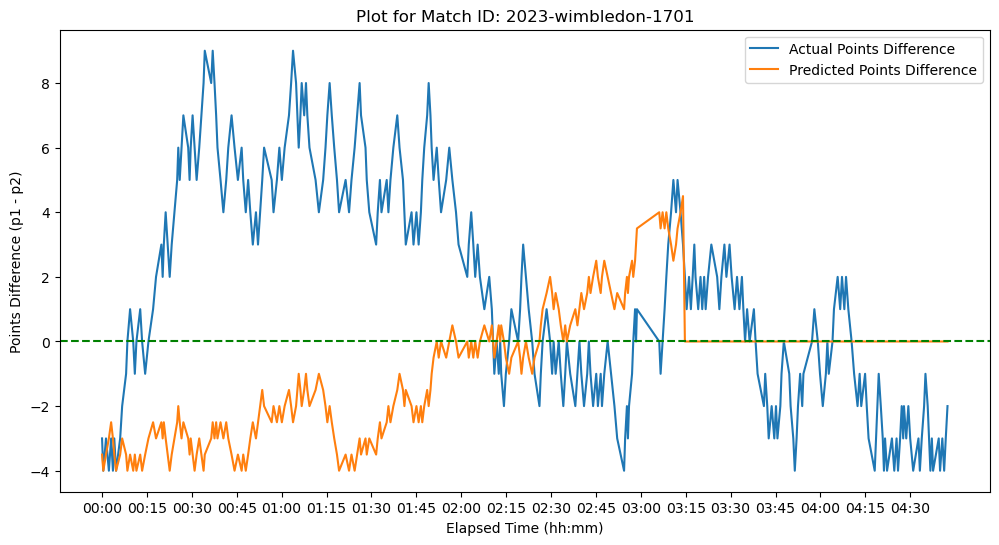

In [56]:
from datetime import datetime, timedelta
def draw_plot(id, subdata, predict_p1_point_win_list, predict_p2_point_win_list,folder_name):
    # Create directory if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    # Set the figure size (width, height)

    plt.figure(figsize=(12, 6))

    # Calculate the number of 1s subtracted by the number of 0s in 'point_victor'
    y_values = abs(subdata[match[id]]['p1_points_won'] - subdata[match[id]]['p2_points_won'])-4.0

    # Get the 'elapsed_time' values and convert them to total number of seconds
    x_values = subdata[match[id]]['elapsed_time'].dt.total_seconds()

    # Create the bar plot
    plt.plot(x_values, y_values, label='Actual Points Difference in absolute value - 4.0')

    # Add the predicted points difference
    predicted_y_values = abs(np.array(predict_p1_point_win_list[id]) - np.array(predict_p2_point_win_list[id]))*0.5-4.0
    # Ensure predicted_y_values is not longer than x_values
    if len(predicted_y_values) > len(x_values):
        predicted_y_values = predicted_y_values[:len(x_values)]
    elif len(predicted_y_values) < len(x_values):
        predicted_y_values = np.pad(predicted_y_values, (0, len(x_values) - len(predicted_y_values)), 'constant')
    plt.plot(x_values, predicted_y_values, label='Predicted Points Difference in absolute value -4.0')

    # Calculate the integral of y_values and predicted_y_values
    y_values_integral = np.cumsum(y_values)
    predicted_y_values_integral = np.cumsum(predicted_y_values)

    # Plot the integral of y_values
    plt.plot(x_values, y_values_integral, label='Integral of Actual Points Difference')

    # Plot the integral of predicted_y_values
    plt.plot(x_values, predicted_y_values_integral, label='Integral of Predicted Points Difference')

    # Create xticks every 15 minutes
    x_ticks = np.arange(min(x_values), max(x_values), 15*60)  # 15 minutes in seconds
    x_tick_labels = [(datetime.min + timedelta(seconds=s)).time().strftime('%H:%M') for s in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

    # Add x and y labels
    plt.xlabel('Elapsed Time (hh:mm)')
    plt.ylabel('Points Difference (p1 - p2)')

    # Add a title
    plt.title(f'Plot for Match ID: {match[id]}')

    # Add a horizontal line at y=0
    plt.axhline(0, color="green", linestyle='--')

    # Add a legend
    plt.legend()

    # Save the plot in the directory

    plt.savefig(f'{folder_name}/{match[id]}.png')
    # Show the plot
    #plt.show()

# Usage:
for id in range(len(match)):
    draw_plot(id, subdata, predict_p1_point_win_list, predict_p2_point_win_list, "plots")